In [1]:
import os
import yaml
import json
import logging
import torch
import numpy as np
import pandas as pd
import xarray as xr
import seqdata as sd
import seqpro as sp

import matplotlib.pyplot as plt
import seaborn as sns

from tangermeme.predict import predict

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


/cellar/users/aklie/opt/miniconda3/envs/eugene_tools/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#
name = "K562_ATAC-seq_bias_fold_0"
command = "fit"
path_fit = "/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/eugene/bias_model/fold_0/0.5"
threads = 4
random_state = 1234

In [50]:
import os
from dominate.tags import *
from dominate.util import raw
from dominate import document

def generate_html_report(output_dir, filename):
    # Validate output_dir and ensure filename is within it
    if not os.path.isdir(output_dir):
        raise ValueError(f"The specified output directory does not exist: {output_dir}")
    
    save_path = os.path.join(output_dir, filename)

    # Relative paths to images and logs
    loss_plot_path = "K562_ATAC-seq_bias_fold_0_loss.png"
    counts_scatter_path = "K562_ATAC-seq_bias_fold_0_counts_scatter.png"
    loci_counts_scatter_path = "K562_ATAC-seq_bias_fold_0_loci_counts_scatter.png"
    neg_counts_scatter_path = "K562_ATAC-seq_bias_fold_0_neg_counts_scatter.png"

    # Relative paths to motif discovery reports
    modisco_counts_report_path = os.path.join("K562_ATAC-seq_bias_fold_0_modisco_counts_report", "motifs.html")
    modisco_profile_report_path = os.path.join("K562_ATAC-seq_bias_fold_0_modisco_profile_report", "motifs.html")
    
    # Read and preprocess motif discovery tables
    def preprocess_motif_table(table_path, prefix):
        full_path = os.path.join(output_dir, table_path)
        if not os.path.exists(full_path):
            return ""
        table_html = open(full_path).read()
        table_html = (table_html.replace("./", f"./{prefix}/")
                                .replace("width=\"240\"", "width=\"240\", class=\"cover\"")
                                .replace(">pos_patterns.pattern", ">pos_")
                                .replace(">neg_patterns.pattern", ">neg_")
                                .replace("modisco_cwm_fwd", "cwm_fwd")
                                .replace("modisco_cwm_rev", "cwm_rev")
                                .replace("num_seqlets", "NumSeqs")
                                .replace("dataframe", "new")
                                .replace(os.path.abspath(output_dir), "."))  # Replace absolute paths with relative
        return remove_negs(table_html)
    
    def remove_negs(tables):
        new_lines = []
        set_flag = True
        lines = tables.split("\n")
        jdx = 0
        for idx in range(len(lines) - 1):
            if jdx == 15:
                set_flag = True
                jdx = 0
            if "neg_" in lines[idx + 1]:
                set_flag = False
                jdx = 0
            if set_flag:
                new_lines.append(lines[idx])
            else:
                jdx += 1
        new_lines.append(lines[-1])
        return "\n".join(new_lines)
    
    table_counts = preprocess_motif_table(modisco_counts_report_path, "modisco_counts")
    table_profile = preprocess_motif_table(modisco_profile_report_path, "modisco_profile")
    
    # Generate HTML report
    doc = document(title="Model Training Report")
    
    with doc:
        h1("Model Training Report")
        
        # Section 1: Training Log
        h2("1. Training Log")
        p("This section includes details of the model's training process, such as loss over epochs.")
        if os.path.exists(os.path.join(output_dir, loss_plot_path)):
            img(src=loss_plot_path, width="600px", alt="Loss Plot")
        else:
            p("Training log not found.")
        
        # Section 2: Performance
        h2("2. Performance")
        p("This section includes scatter plots to evaluate the model's performance metrics.")
        with div(style="display: flex; flex-wrap: nowrap; justify-content: space-around;"):
            with div(style="text-align: center; margin: 10px;"):
                p("Counts Scatter")
                img(src=counts_scatter_path, width="300px", alt="Counts Scatter")
            with div(style="text-align: center; margin: 10px;"):
                p("Loci Counts Scatter")
                img(src=loci_counts_scatter_path, width="300px", alt="Loci Counts Scatter")
            with div(style="text-align: center; margin: 10px;"):
                p("Negative Counts Scatter")
                img(src=neg_counts_scatter_path, width="300px", alt="Negative Counts Scatter")
        
        # Section 3: Motif Discovery
        h2("3. Motif Discovery")
        p("This section provides the motifs discovered by the model during training. Both counts and profile motifs are displayed below.")
        
        h3("Counts Modisco")
        div(raw(table_counts))
        
        h3("Profile Modisco")
        div(raw(table_profile))
    
    # Save the report
    with open(save_path, "w") as f:
        f.write(doc.render())
    
    print(f"Report generated and saved to: {save_path}")

# Example usage
# generate_html_report(output_dir="/path/to/output", filename="report.html")


In [51]:
# Example usage
generate_html_report(
    output_dir="/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/eugene/bias_model/fold_0/0.5", 
    filename="report.html"
)


Report generated and saved to: /cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/eugene/bias_model/fold_0/0.5/report.html


# Training curve

In [44]:
path_log = os.path.join(path_fit, f"{name}.log")

In [5]:
log_df = pd.read_csv(path_log, sep="\t")
log_df

,Epoch,Iteration,Training Time,Validation Time,Training MNLL,Training Count MSE,Validation MNLL,Validation Profile Pearson,Validation Count Pearson,Validation Count MSE,Saved?
0,0,0,1.425833,2.352996,209.667389,16.597023,219.610199,0.159568,-0.039426,11.353215,True
1,0,1000,23.584404,2.148982,145.292679,1.310280,161.701920,0.400439,0.464912,0.998143,True
2,0,2000,23.421834,2.150072,150.173279,1.082249,161.074203,0.404081,0.569843,0.827932,True
3,0,3000,23.494235,2.154051,145.091034,0.791890,160.994904,0.404806,0.630028,0.629615,True
4,1,4000,16.210235,2.152221,151.805573,0.972422,160.687576,0.406820,0.652214,0.633862,True
...,...,...,...,...,...,...,...,...,...,...,...
158,48,158000,23.439969,2.146935,162.585571,0.681021,160.104416,0.410528,0.712675,0.506258,False
159,49,159000,3.043618,2.148339,146.458221,0.309538,160.136459,0.410534,0.705417,0.501665,False
160,49,160000,23.445565,2.146894,150.782242,0.705126,160.127502,0.410166,0.710235,0.525256,False
161,49,161000,23.439605,2.147896,149.206848,0.458097,160.101349,0.410636,0.706300,0.533849,False


In [9]:
alpha = 5.9

In [10]:
log_df["Training Loss"] = log_df["Training MNLL"] + alpha*log_df["Training Count MSE"]
log_df["Validation Loss"] = log_df["Validation MNLL"] + alpha*log_df["Validation Count MSE"]

In [11]:
def plot_training_curves(
    log_df: pd.DataFrame, 
    ax=None, 
    save=None
) -> plt.Axes:
    """
    Plot training curves from a log file.

    Parameters
    ----------
    log_df : pd.DataFrame
        DataFrame containing the log file.
    ax : matplotlib.pyplot.Axes, optional
        Axes to plot on, by default None

    Returns
    -------
    matplotlib.pyplot.Axes

    """
    if ax is None:
        _, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True)

    log_df = log_df.set_index("Iteration")

    # Line plot of "Training Loss", "Validation Loss"
    ax[0].plot(log_df["Training Loss"], label="Training Loss")
    ax[0].plot(log_df["Validation Loss"], label="Validation Val Loss")

    # Line plot of "Validation Count Pearson"
    ax[1].plot(log_df["Validation Count Pearson"], label="Validation Count Pearson")
    ax[1].plot(log_df["Validation Profile Pearson"], label="Validation Profile Pearson")

    # Plot last point in both where "Saved?" is True
    last_saved = log_df[log_df["Saved?"] == True].index[-1]
    ax[0].axvline(last_saved, color="black", linestyle="--", label="Checkpoint")
    ax[1].axvline(last_saved, color="black", linestyle="--", label="Checkpoint")

    # Set labels
    ax[0].set_xlabel("Iteration")
    ax[1].set_xlabel("Iteration")
    ax[0].set_ylabel("Loss")
    ax[1].set_ylabel("Pearson Correlation Coefficient")
    ax[0].legend()
    ax[1].legend()

    # Add a little room to y-axis upper limit
    ax[0].set_ylim(ax[0].get_ylim()[0], ax[0].get_ylim()[1] * 1.1)
    ax[1].set_ylim(ax[1].get_ylim()[0], ax[1].get_ylim()[1] * 1.1)

    plt.tight_layout()

    if save:    
        plt.savefig(save, dpi=300, bbox_inches="tight")
        plt.close()        
        
    return ax

array([<Axes: xlabel='Iteration', ylabel='Loss'>,
       <Axes: xlabel='Iteration', ylabel='Pearson Correlation Coefficient'>],
      dtype=object)

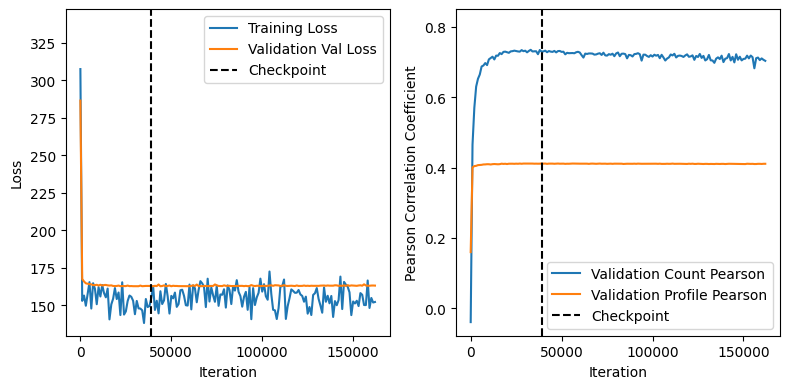

In [12]:
plot_training_curves(log_df)

# Performance

# Modisco

In [32]:
table_profile = open(os.path.join("/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/eugene/bias_model/fold_0/0.5/K562_ATAC-seq_bias_fold_0_modisco_counts_report/motifs.html")).read().replace("./","./modisco_profile/").replace("width=\"240\"","width=\"240\", class=\"cover\"").replace(">pos_patterns.pattern",">pos_").replace(">neg_patterns.pattern",">neg_").replace("modisco_cwm_fwd","cwm_fwd").replace("modisco_cwm_rev","cwm_rev").replace("num_seqlets","NumSeqs").replace("dataframe","new")
table_counts = open(os.path.join("/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/eugene/bias_model/fold_0/0.5/K562_ATAC-seq_bias_fold_0_modisco_profile_report/motifs.html")).read().replace("./","./modisco_counts/").replace("width=\"240\"","width=\"240\", class=\"cover\"").replace(">pos_patterns.pattern",">pos_").replace(">neg_patterns.pattern",">neg_").replace("modisco_cwm_fwd","cwm_fwd").replace("modisco_cwm_rev","cwm_rev").replace("num_seqlets","NumSeqs").replace("dataframe","new")

In [33]:
def remove_negs(tables):
		new_lines=[]
		set_flag = True
		lines = tables.split("\n")
		jdx=0
		for idx in range(len(lines)-1):
			
			if jdx==15:
				set_flag = True
				jdx=0
	
			if "neg_" in lines[idx+1]:
				set_flag=False
				jdx = 0
		
			if set_flag:
				new_lines.append(lines[idx])
			else:
				jdx+=1
		new_lines.append(lines[-1])
		return  "\n".join(new_lines)

In [34]:
table_profile = remove_negs(table_profile)
table_counts = remove_negs(table_counts)

In [35]:
html = f'''
			<body>
				 {table_profile}
			</body>
			<body>
				 {table_counts}
			</body>
		'''

In [ ]:
# Render the HTML content in a Jupyter notebook
from IPython.display import HTML
HTML(html)

pattern,NumSeqs,cwm_fwd,cwm_rev,match0,qval0,match0_logo,match1,qval1,match1_logo,match2,qval2,match2_logo
pos__0,144,,,SP1_MOUSE.H11MO.0.A,0.000498,,SP2_HUMAN.H11MO.0.A,0.000498,,SP2_MOUSE.H11MO.0.B,0.000498,
pos__1,75,,,SP2_HUMAN.H11MO.0.A,0.000169,,SP2_MOUSE.H11MO.0.B,0.000169,,ZFX_MOUSE.H11MO.0.B,0.000659,
pos__2,75,,,SP1_MOUSE.H11MO.0.A,0.000213,,SP2_HUMAN.H11MO.0.A,0.000437,,SP2_MOUSE.H11MO.0.B,0.000437,
pos__3,71,,,ZFX_MOUSE.H11MO.0.B,0.119012,,SP2_HUMAN.H11MO.0.A,0.119012,,SP2_MOUSE.H11MO.0.B,0.119012,
pos__4,64,,,SP1_HUMAN.H11MO.0.A,0.000927,,SP2_HUMAN.H11MO.0.A,0.000927,,SP2_MOUSE.H11MO.0.B,0.000927,
pos__5,56,,,NFIB_MOUSE.H11MO.0.C,0.201760,,TN5_2,0.201760,,CTCF_MOUSE.H11MO.0.A,0.300628,
pos__6,49,,,ZN331_HUMAN.H11MO.0.C,0.984754,,KLF3_HUMAN.H11MO.0.B,0.984754,,KLF3_MOUSE.H11MO.0.A,0.984754,
pos__7,44,,,SP1_MOUSE.H11MO.0.A,0.003042,,ZFX_MOUSE.H11MO.0.B,0.003042,,SP2_HUMAN.H11MO.0.A,0.003042,
pos__8,43,,,SP1_MOUSE.H11MO.0.A,0.000905,,SP2_HUMAN.H11MO.0.A,0.000905,,SP2_MOUSE.H11MO.0.B,0.000905,
pattern,NumSeqs,cwm_fwd,cwm_rev,match0,qval0,match0_logo,match1,qval1,match1_logo,match2,qval2,match2_logo


In [ ]:
# Render the HTML content


In [14]:
table_profile

'<table border="1" class="new">\n  <thead>\n    <tr style="text-align: right;">\n      <th>pattern</th>\n      <th>NumSeqs</th>\n      <th>cwm_fwd</th>\n      <th>cwm_rev</th>\n      <th>match0</th>\n      <th>qval0</th>\n      <th>match0_logo</th>\n      <th>match1</th>\n      <th>qval1</th>\n      <th>match1_logo</th>\n      <th>match2</th>\n      <th>qval2</th>\n      <th>match2_logo</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <td>pos__0</td>\n      <td>144</td>\n      <td><img src="/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/eugene/bias_model/fold_0/0.5/K562_ATAC-seq_bias_fold_0_modisco_counts_report/trimmed_logos/pos_patterns.pattern_0.cwm.fwd.png" width="240", class="cover" ></td>\n      <td><img src="/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/eugene/bias_model/fold_0/0.5/K562_ATAC-seq_bias_fold_0_modisco_counts_report/trimmed_logos/pos_patterns.pattern_0.cwm.rev.png" width="240", class="cover" ></td>\n      <td>SP1_MOUSE

In [452]:
# 
path_params = "/cellar/users/aklie/projects/ML4GLand/EUGENe/examples/prep_dataset/SC.delta/SC.delta.sample.yaml"

In [453]:
fold = "fold_0"
path_sdata = "/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/eugene/prep_dataset/0.5/K562_ATAC-seq.minimal.seqdata"
path_model = "/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/eugene/bias_model/fold_0/K562_ATAC-seq_bias_fold_0.torch"
path_log = "/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/eugene/bias_model/fold_0/K562_ATAC-seq_bias_fold_0.log"

,Epoch,Iteration,Training Time,Validation Time,Training MNLL,Training Count MSE,Validation MNLL,Validation Profile Pearson,Validation Count Pearson,Validation Count MSE,Saved?
0,0,0,1.440450,2.406086,281.909454,16.431974,268.145782,0.149895,-0.060813,8.862803,True
1,0,1000,23.733371,2.191658,180.004929,0.833457,193.388855,0.436686,0.358089,1.051489,True
2,0,2000,23.588288,2.192507,189.285858,1.653532,192.617691,0.440426,0.474676,0.851948,True
3,0,3000,23.659849,2.195989,182.012177,0.940332,192.711365,0.440170,0.565808,0.839905,False
4,1,4000,16.772296,2.196015,179.665634,1.001633,192.069122,0.443888,0.603764,0.637821,True
...,...,...,...,...,...,...,...,...,...,...,...
156,48,156000,23.596840,2.188348,192.921707,0.755526,191.229263,0.448178,0.709911,0.512921,False
157,48,157000,23.600270,2.188734,193.110962,0.311195,191.275604,0.447867,0.712898,0.497880,False
158,49,158000,4.730215,2.186760,186.580719,0.392153,191.265671,0.447858,0.711775,0.519822,False
159,49,159000,23.600533,2.187750,181.690308,0.445819,191.303192,0.447717,0.701241,0.505963,False


In [455]:
# log dataframe
alpha = 5.9
log_df["Training Loss"] = log_df["Training MNLL"] + alpha*log_df["Training Count MSE"]
log_df["Validation Loss"] = log_df["Validation MNLL"] + alpha*log_df["Validation Count MSE"]
log_df.head()

,Epoch,Iteration,Training Time,Validation Time,Training MNLL,Training Count MSE,Validation MNLL,Validation Profile Pearson,Validation Count Pearson,Validation Count MSE,Saved?,Training Loss,Validation Loss
0,0,0,1.440450,2.406086,281.909454,16.431974,268.145782,0.149895,-0.060813,8.862803,True,378.858103,320.436323
1,0,1000,23.733371,2.191658,180.004929,0.833457,193.388855,0.436686,0.358089,1.051489,True,184.922322,199.592643
2,0,2000,23.588288,2.192507,189.285858,1.653532,192.617691,0.440426,0.474676,0.851948,True,199.041698,197.644187
3,0,3000,23.659849,2.195989,182.012177,0.940332,192.711365,0.440170,0.565808,0.839905,False,187.560135,197.666802
4,1,4000,16.772296,2.196015,179.665634,1.001633,192.069122,0.443888,0.603764,0.637821,True,185.575268,195.832266


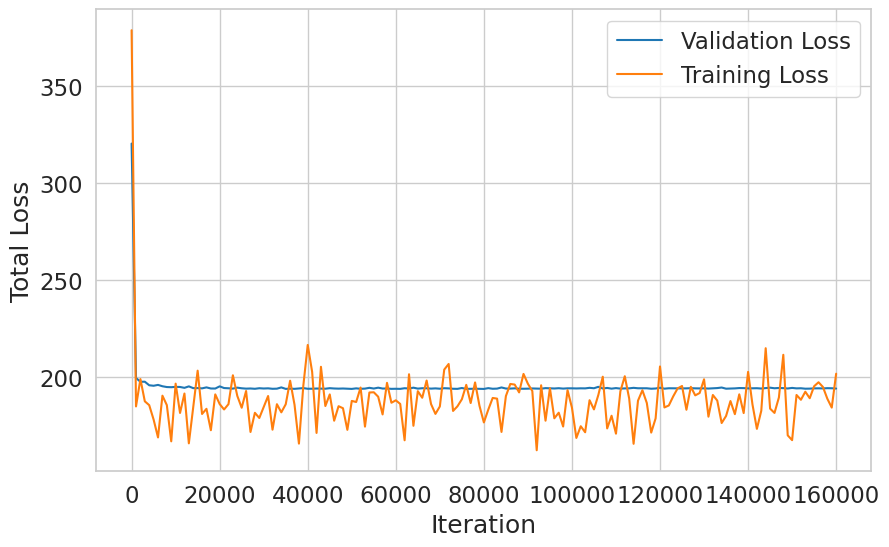

In [456]:
# Plot losses vs "Iteration"
with sns.plotting_context("notebook", font_scale=1.5):
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=log_df, x="Iteration", y="Validation Loss", label="Validation Loss")
    sns.lineplot(data=log_df, x="Iteration", y="Training Loss", label="Training Loss")
    plt.xlabel("Iteration")
    plt.ylabel("Total Loss")

In [457]:
model = torch.load(path_model).cuda()
model

/tmp/ipykernel_2284757/3915197513.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(path_model).cuda()


BPNet(
  (iconv): Conv1d(4, 128, kernel_size=(21,), stride=(1,), padding=(10,))
  (irelu): ReLU()
  (rconvs): ModuleList(
    (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
    (1): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
    (2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
    (3): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
  )
  (rrelus): ModuleList(
    (0-3): 4 x ReLU()
  )
  (fconv): Conv1d(128, 1, kernel_size=(75,), stride=(1,), padding=(37,))
  (linear): Linear(in_features=128, out_features=1, bias=True)
)

In [458]:
sdata = sd.open_zarr(path_sdata)
sdata

<xarray.Dataset> Size: 9GB
Dimensions:     (_sequence: 539410, cov_sample: 1, _length: 3138)
Coordinates:
  * _sequence   (_sequence) <U15 32MB 'loci_0' 'loci_1' ... 'negative_269691'
  * cov_sample  (cov_sample) object 8B 'SC.delta'
Dimensions without coordinates: _length
Data variables: (12/18)
    blockCount  (_sequence) float64 4MB dask.array<chunksize=(33715,), meta=np.ndarray>
    chrom       (_sequence) object 4MB dask.array<chunksize=(67427,), meta=np.ndarray>
    chromEnd    (_sequence) int64 4MB dask.array<chunksize=(33715,), meta=np.ndarray>
    chromStart  (_sequence) int64 4MB dask.array<chunksize=(33715,), meta=np.ndarray>
    cov         (_sequence, cov_sample, _length) float32 7GB dask.array<chunksize=(1000, 1, 3138), meta=np.ndarray>
    fold_0      (_sequence) <U5 11MB dask.array<chunksize=(33714,), meta=np.ndarray>
    ...          ...
    score       (_sequence) float64 4MB dask.array<chunksize=(33715,), meta=np.ndarray>
    seq         (_sequence, _length) |S1 2GB dask.array<chunksize=(1000, 3138), meta=np.ndarray>
    strand      (_sequence) object 4MB dask.array<chunksize=(67427,), meta=np.ndarray>
    thickEnd    (_sequence) float64 4MB dask.array<chunksize=(33715,), meta=np.ndarray>
    thickStart  (_sequence) float64 4MB dask.array<chunksize=(33715,), meta=np.ndarray>
    type        (_sequence) <U8 17MB dask.array<chunksize=(16857,), meta=np.ndarray>
Attributes:
    length_dim:    _length
    max_jitter:    512
    sequence_dim:  _sequence

In [459]:
seq_var = "seq"
cov_var = "cov"

In [460]:
seq_length = 2114
target_length = 1000
trimming = (seq_length - target_length) // 2
seqs_start = (sdata.dims["_length"] // 2) - (seq_length // 2)
counts_start = (sdata.dims["_length"] // 2) - (target_length // 2)
print(f"Sequence length is {seq_length}")
print(f"Target length is {target_length}")
print(f"Trimming is {trimming}\n")

Sequence length is 2114
Target length is 1000
Trimming is 557



/tmp/ipykernel_2284757/3124990439.py:4: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  seqs_start = (sdata.dims["_length"] // 2) - (seq_length // 2)
/tmp/ipykernel_2284757/3124990439.py:5: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  counts_start = (sdata.dims["_length"] // 2) - (target_length // 2)


In [461]:
test_idx = np.where(sdata[fold] == "test")[0]
test_data = sdata.isel(_sequence=test_idx)

In [462]:
true_counts = torch.tensor(test_data[cov_var].values[..., counts_start:counts_start + target_length].sum(axis=-1), dtype=torch.float32)
test_data["log_counts"] = xr.DataArray(torch.log(true_counts+1).numpy(), dims=["_sequence", "cov_sample"])

In [463]:
X_test = torch.tensor(sp.ohe(test_data["seq"].values[:, seqs_start:seqs_start + seq_length], alphabet=sp.DNA).transpose(0, 2, 1), dtype=torch.float32)
y_test = torch.tensor(test_data["cov"].values[..., counts_start:counts_start + target_length], dtype=torch.float32)

In [464]:
y_profiles, y_counts = predict(model, X_test, batch_size=128, device="cuda", verbose=True)

100%|██████████| 839/839 [00:09<00:00, 84.09it/s]


In [465]:
test_data[f"{fold}_log_counts_pred"] = xr.DataArray(y_counts.cpu().numpy(), dims=["_sequence", "cov_sample"])

In [466]:
test_data[f"{fold}_profile_pred"] = xr.DataArray(y_profiles.cpu().numpy(), dims=["_sequence", "cov_sample", "_target_length"])     

In [467]:
from eugene.plot.performance import scatter

In [468]:
type_msk = (test_data["type"] == "loci")

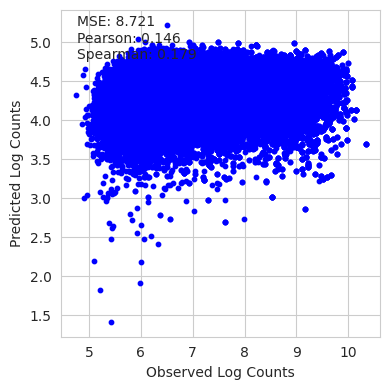

In [469]:
loci_counts = test_data["log_counts"].values[type_msk]
loci_counts_pred = test_data[f"{fold}_log_counts_pred"].values[type_msk]
scatter(
    loci_counts,
    loci_counts_pred,
    figsize=(4, 4),
    xlabel="Observed Log Counts",
    ylabel="Predicted Log Counts",
    save=None,
    density=False,
    add_reference_line=False,
    return_axes=False,
)

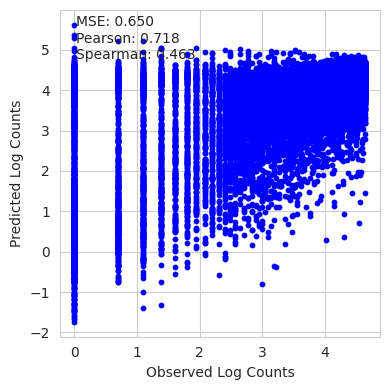

In [470]:
neg_counts = test_data["log_counts"].values[~type_msk]
neg_counts_pred = test_data[f"{fold}_log_counts_pred"].values[~type_msk]
scatter(
    neg_counts,
    neg_counts_pred,
    figsize=(4, 4),
    xlabel="Observed Log Counts",
    ylabel="Predicted Log Counts",
    save=None,
    density=False,
    add_reference_line=False,
    return_axes=False,
)

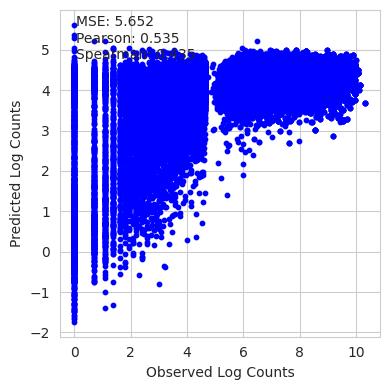

In [471]:
counts = test_data["log_counts"].values
counts_pred = test_data[f"{fold}_log_counts_pred"].values
scatter(
    counts,
    counts_pred,
    figsize=(4, 4),
    xlabel="Observed Log Counts",
    ylabel="Predicted Log Counts",
    save=None,
    density=False,
    add_reference_line=False,
    return_axes=False,
)

In [472]:
test_data.type.values

array(['loci', 'loci', 'loci', ..., 'negative', 'negative', 'negative'],
      dtype='<U8')

In [473]:
# sample 30k peaks
test_loci_idx = np.where(test_data["type"] == "loci")[0]
test_loci = test_data.isel(_sequence=test_loci_idx)
test_loci

<xarray.Dataset> Size: 1GB
Dimensions:                 (_sequence: 66474, cov_sample: 1, _length: 3138,
                             _target_length: 1000)
Coordinates:
  * _sequence               (_sequence) <U15 4MB 'loci_0' ... 'loci_223494'
  * cov_sample              (cov_sample) object 8B 'SC.delta'
Dimensions without coordinates: _length, _target_length
Data variables: (12/21)
    blockCount              (_sequence) float64 532kB dask.array<chunksize=(31165,), meta=np.ndarray>
    chrom                   (_sequence) object 532kB dask.array<chunksize=(31165,), meta=np.ndarray>
    chromEnd                (_sequence) int64 532kB dask.array<chunksize=(31165,), meta=np.ndarray>
    chromStart              (_sequence) int64 532kB dask.array<chunksize=(31165,), meta=np.ndarray>
    cov                     (_sequence, cov_sample, _length) float32 834MB dask.array<chunksize=(1000, 1, 3138), meta=np.ndarray>
    fold_0                  (_sequence) <U5 1MB dask.array<chunksize=(31165,), meta=np.ndarray>
    ...                      ...
    thickEnd                (_sequence) float64 532kB dask.array<chunksize=(31165,), meta=np.ndarray>
    thickStart              (_sequence) float64 532kB dask.array<chunksize=(31165,), meta=np.ndarray>
    type                    (_sequence) <U8 2MB dask.array<chunksize=(16857,), meta=np.ndarray>
    log_counts              (_sequence, cov_sample) float32 266kB 6.774 ... 5...
    fold_0_log_counts_pred  (_sequence, cov_sample) float32 266kB 4.515 ... 4...
    fold_0_profile_pred     (_sequence, cov_sample, _target_length) float32 266MB ...
Attributes:
    length_dim:    _length
    max_jitter:    512
    sequence_dim:  _sequence

In [479]:
# Subsample 30k peaks
random_idx = np.random.choice(test_loci.dims["_sequence"], 100, replace=False)
test_loci = test_loci.isel(_sequence=sorted(random_idx))

/tmp/ipykernel_2284757/3255110629.py:2: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  random_idx = np.random.choice(test_loci.dims["_sequence"], 100, replace=False)


In [486]:
X = torch.tensor(sp.ohe(test_loci["seq"].values[:, seqs_start:seqs_start + seq_length], alphabet=sp.DNA).transpose(0, 2, 1), dtype=torch.float32)
X = X[X.sum(dim=(1, 2)) == X.shape[-1]]
X.shape

torch.Size([100, 4, 2114])

In [487]:
from bpnetlite.bpnet import ControlWrapper
from bpnetlite.bpnet import CountWrapper
from bpnetlite.bpnet import ProfileWrapper
from tangermeme.deep_lift_shap import deep_lift_shap
import modiscolite
from modiscolite.util import calculate_window_offsets

In [488]:
wrapper = ProfileWrapper(ControlWrapper(model)).cuda().eval()

In [483]:
dtype = torch.float64

In [489]:
wrapper(X[:1].cuda().to(dtype))

tensor([[2.9530]], device='cuda:0', dtype=torch.float64,
       grad_fn=<SumBackward1>)

In [490]:
from bpnetlite.bpnet import _ProfileLogitScaling
from tangermeme.deep_lift_shap import _nonlinear

In [491]:
X_attr = deep_lift_shap(
    wrapper.type(dtype), 
    X.type(dtype),
    hypothetical=True,
    additional_nonlinear_ops={_ProfileLogitScaling: _nonlinear}, 
    n_shuffles=20,
    batch_size=64,
    random_state=1234,
    verbose=True,
    warning_threshold=1e-4)

100%|██████████| 2000/2000 [00:05<00:00, 336.06it/s]


In [449]:
test_loci["X_ohe"] = xr.DataArray(X.cpu().numpy(), dims=["_sequence", "_alphabet", "_trimmed_length"])
test_loci["X_attr"] = xr.DataArray(X_attr.cpu().numpy(), dims=["_sequence", "_alphabet", "_trimmed_length"])

In [450]:
test_loci

<xarray.Dataset> Size: 121MB
Dimensions:                 (_sequence: 1000, cov_sample: 1, _length: 3138,
                             _target_length: 1000, _alphabet: 4,
                             _trimmed_length: 2114)
Coordinates:
  * _sequence               (_sequence) <U15 60kB 'loci_7299' ... 'loci_210685'
  * cov_sample              (cov_sample) object 8B 'SC.delta'
Dimensions without coordinates: _length, _target_length, _alphabet,
                                _trimmed_length
Data variables: (12/23)
    blockCount              (_sequence) float64 8kB dask.array<chunksize=(6,), meta=np.ndarray>
    chrom                   (_sequence) object 8kB dask.array<chunksize=(6,), meta=np.ndarray>
    chromEnd                (_sequence) int64 8kB dask.array<chunksize=(6,), meta=np.ndarray>
    chromStart              (_sequence) int64 8kB dask.array<chunksize=(6,), meta=np.ndarray>
    cov                     (_sequence, cov_sample, _length) float32 13MB dask.array<chunksize=(1, 1, 3138), meta=np.ndarray>
    fold_0                  (_sequence) <U5 20kB dask.array<chunksize=(6,), meta=np.ndarray>
    ...                      ...
    type                    (_sequence) <U8 32kB dask.array<chunksize=(1,), meta=np.ndarray>
    log_counts              (_sequence, cov_sample) float32 4kB 6.25 ... 8.136
    fold_0_log_counts_pred  (_sequence, cov_sample) float32 4kB 4.485 ... 4.512
    fold_0_profile_pred     (_sequence, cov_sample, _target_length) float32 4MB ...
    X_ohe                   (_sequence, _alphabet, _trimmed_length) float32 34MB ...
    X_attr                  (_sequence, _alphabet, _trimmed_length) float64 68MB ...
Attributes:
    length_dim:    _length
    max_jitter:    512
    sequence_dim:  _sequence

In [446]:
center = X.shape[2] // 2
start, end = calculate_window_offsets(center, 500)
sequences = X.numpy()[:, :, start:end].transpose(0, 2, 1).astype('float32')
attributions = X_attr.numpy()[:, :, start:end].transpose(0, 2, 1).astype('float32')
start, end

(807, 1307)

In [447]:
sequences = X.numpy()[:, :, start:end].transpose(0, 2, 1).astype('float32')
attributions = X_attr.numpy()[:, :, start:end].transpose(0, 2, 1).astype('float32')

In [ ]:
pos_patterns, neg_patterns = modiscolite.tfmodisco.TFMoDISco(
    hypothetical_contribs=attributions, 
    one_hot=sequences,
    max_seqlets_per_metacluster=50_000,
    sliding_window_size=20,
    flank_size=5,
    target_seqlet_fdr=0.05,
    n_leiden_runs=2,
    verbose=True
)

Using 203 positive seqlets
Extracted 812 negative seqlets


In [385]:
modiscolite.io.save_hdf5("test.h5", pos_patterns, neg_patterns, 500)

In [386]:
modiscolite.report.report_motifs(
    modisco_h5py="test.h5", 
    output_dir="report",
    img_path_suffix="report", 
    meme_motif_db="/cellar/users/aklie/projects/ML4GLand/tutorials/data/motifs.meme.txt",
    is_writing_tomtom_matrix=False,
    top_n_matches=3
)

In [ ]:
np.savez_compressed(os.path.join(path_out, "ohe"), X)

In [ ]:
np.savez_compressed(os.path.join(path_out, "K562.bias.counts"), X_attr)

In [293]:
from tangermeme.seqlet import recursive_seqlets

seqlets = recursive_seqlets(X_attr.sum(dim=1))
seqlets

,example_idx,start,end,attribution,p-value
0,71,1219,1231,-0.418033,0.000067
1,27,1307,1328,-0.684812,0.000139
2,2,1370,1392,-0.568672,0.000201
3,85,1510,1527,-0.466896,0.000334
4,1,1018,1025,-0.197330,0.000369
...,...,...,...,...,...
221,11,555,560,-0.084604,0.009122
222,7,1261,1265,-0.062980,0.009122
223,53,644,649,-0.078515,0.009376
224,3,953,957,-0.064656,0.009599


In [296]:
seqlets.sort_values("attribution", ascending=False)

,example_idx,start,end,attribution,p-value
138,39,1376,1380,0.009939,0.005879
12,50,1419,1423,0.009257,0.001176
222,7,1261,1265,-0.062980,0.009122
220,71,990,994,-0.063086,0.009017
215,40,1365,1369,-0.063751,0.008673
...,...,...,...,...,...
26,10,1196,1220,-0.526931,0.001890
29,92,1052,1076,-0.553076,0.001954
2,2,1370,1392,-0.568672,0.000201
5,49,1126,1150,-0.572527,0.000374


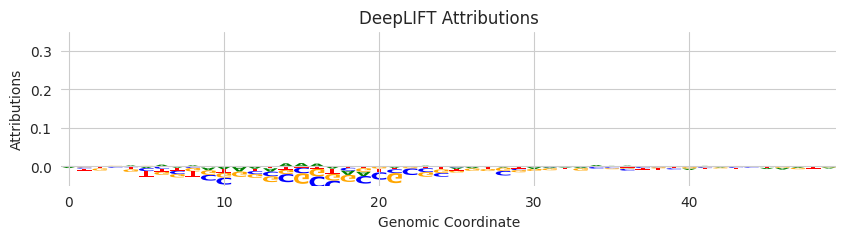

In [297]:
from matplotlib import pyplot as plt
import seaborn; seaborn.set_style('whitegrid')
from tangermeme.plot import plot_logo

plt.figure(figsize=(10, 2))
ax = plt.subplot(111)
plot_logo(X_attr[27, :, 1300:1350], ax=ax)

plt.xlabel("Genomic Coordinate")
plt.ylabel("Attributions")
plt.title("DeepLIFT Attributions")
plt.ylim(-0.05, 0.35)
plt.show()

In [258]:
test = sdata[["chrom", "type"]].to_pandas()
crosstab = pd.crosstab(test["chrom"], test["type"])
crosstab

type,loci,negative
chrom,,
chr1,31165,14132
chr10,11948,14805
chr11,13643,11358
chr12,12529,12759
chr13,4681,9677
chr14,6836,9990
chr15,8645,8093
chr16,9016,10593
chr17,11221,10655


In [390]:
X_attr.shape

torch.Size([1000, 4, 2114])

In [391]:
test_loci["X_ohe"] = xr.DataArray(X.cpu().numpy(), dims=["_sequence", "_alphabet", "_trimmed_length"])
test_loci["X_attr"] = xr.DataArray(X_attr.cpu().numpy(), dims=["_sequence", "_alphabet", "_trimmed_length"])

In [393]:
X_attr

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0

In [392]:
test_loci

<xarray.Dataset> Size: 121MB
Dimensions:                 (_sequence: 1000, cov_sample: 1, _length: 3138,
                             _target_length: 1000, _alphabet: 4,
                             _trimmed_length: 2114)
Coordinates:
  * _sequence               (_sequence) <U15 60kB 'loci_25377' ... 'loci_166175'
  * cov_sample              (cov_sample) object 8B 'SC.delta'
Dimensions without coordinates: _length, _target_length, _alphabet,
                                _trimmed_length
Data variables: (12/23)
    blockCount              (_sequence) float64 8kB dask.array<chunksize=(2,), meta=np.ndarray>
    chrom                   (_sequence) object 8kB dask.array<chunksize=(2,), meta=np.ndarray>
    chromEnd                (_sequence) int64 8kB dask.array<chunksize=(2,), meta=np.ndarray>
    chromStart              (_sequence) int64 8kB dask.array<chunksize=(2,), meta=np.ndarray>
    cov                     (_sequence, cov_sample, _length) float32 13MB dask.array<chunksize=(1, 1, 3138), meta=np.ndarray>
    fold_0                  (_sequence) <U5 20kB dask.array<chunksize=(2,), meta=np.ndarray>
    ...                      ...
    type                    (_sequence) <U8 32kB dask.array<chunksize=(1,), meta=np.ndarray>
    log_counts              (_sequence, cov_sample) float32 4kB 8.794 ... 7.758
    fold_0_log_counts_pred  (_sequence, cov_sample) float32 4kB 4.171 ... 4.556
    fold_0_profile_pred     (_sequence, cov_sample, _target_length) float32 4MB ...
    X_ohe                   (_sequence, _alphabet, _trimmed_length) float32 34MB ...
    X_attr                  (_sequence, _alphabet, _trimmed_length) float64 68MB ...
Attributes:
    length_dim:    _length
    max_jitter:    512
    sequence_dim:  _sequence